This notebook looks at the "vote decay" of users. The New Yorker caption contest organizer, Bob Mankoff, has received many emails like the one below (name/personal details left out for anonymity)

> Here's my issue. 

> First time I encounter something, I might say it's funny. 

> Then it comes back in many forms over and over and it's no longer funny and I wish I could go back to the first one and say it's not funny. 

> But it's funny, and then I can't decide whether to credit everyone with funny or keep hitting unfunny. What I really like to find out is who submitted it first, but often it's slightly different and there may be a best version. Auggh!

> How should we do this???

We can investigate this: we have all the data at hand. We record the timestamp, participant ID and their rating for a given caption. So let's see how votes go after a user has seen $n$ captions!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Reading in data
Let's read in the data. As the last column can contain a non-escaped comma, we have to fix that before doing any analysis.

In [15]:
contest = '514'
# responses = pd.read_csv('../contests/adaptive/{}/participant_responses_LilUCB.csv'.format(contest))
import csv
with open('../contests/random+adaptive/{}/participant-responses.csv'.format(contest), 'r') as f,\
     open('{}.csv'.format(contest), 'w') as g:
    writer = csv.writer(g, delimiter=',')
    for line in f:
        row = line.split(',', 6)
        writer.writerow(row)
responses = pd.read_csv('{}.csv'.format(contest), parse_dates=['Timestamp'])
responses.head()

,Partipipant ID,Response Time (s),Network Delay (s),Timestamp,Rating,Alg label,Target
0,957a6866c48697f3,14.0,4.919720,2016-03-26 11:30:16.023836,3.0,RoundRobin,We keep going back and forth on this.\n
1,957a6866c48697f3,18.0,4.232494,2016-03-26 11:30:41.591800,1.0,LilUCB,I’ve got to say when they tamed the old Wild W...
2,957a6866c48697f3,15.0,7.096749,2016-03-26 11:31:08.001035,2.0,LilUCB,Two hours and we still haven't lost 'em!\n
3,957a6866c48697f3,11.0,3.372743,2016-03-26 11:31:33.304223,1.0,RoundRobin,"I'll tell ya one thing, Sheriff! You ain't sen..."
4,957a6866c48697f3,13.0,4.429243,2016-03-26 11:31:51.482395,2.0,LilUCB,"I knew we were over budget, but this is ridicu..."


## Seeing how many captions a user has seen
This is the workhorse of the notebook: it sees how many captions one participant has seen. I sorted by timestamp (and with an actual timestamp, not a str) to collect the ratings in the order a user has seen. I do not assume that only one user answers at a time.

In [27]:
last_id = None
i = 0
num_responses = []
captions_seen = []
responses = responses.sort_values(by='Timestamp')
# responses = responses[5000:6000]  # debug

In [28]:
captions_seen_by = {}
captions_seen = []
for _, response in responses.iterrows():
    id_, rating = response['Partipipant ID'], response['Rating']
    if id_ not in captions_seen_by:
        captions_seen_by[id_] = 0
    captions_seen_by[id_] += 1
    captions_seen += [captions_seen_by[id_]]
    num_responses += [i]

In [29]:
responses['number of captions seen'] = captions_seen
responses.head()

,Partipipant ID,Response Time (s),Network Delay (s),Timestamp,Rating,Alg label,Target,number of captions seen
110715,w4sssYGcWe5PvSSjMiQlvutGHV7Vel,5.736,0.083666,2016-03-21 22:32:45.855125,1.0,LilUCB,It was a fantasy then and it's a fantasy now.\n,1
110716,w4sssYGcWe5PvSSjMiQlvutGHV7Vel,5.116,0.081959,2016-03-21 22:32:51.999761,1.0,LilUCB,"Law and Order:SWU (special western unit). ""I t...",2
110717,w4sssYGcWe5PvSSjMiQlvutGHV7Vel,4.408,0.075260,2016-03-21 22:32:57.523550,1.0,LilUCB,To think I gave up collecting stamps for this.\n,3
147713,hhWRo33lpAU6FabBwIryFVsqag3kZP,17.096,0.283146,2016-03-22 06:27:22.255157,1.0,LilUCB,that threesome appeared in broke rocking horse...,1
147714,hhWRo33lpAU6FabBwIryFVsqag3kZP,5.247,0.154305,2016-03-22 06:27:39.752392,1.0,RoundRobin,And you said long form was dead.\n,2


## Viewing the data
Now let's format the data to view it. We can view the data in two ways: as we only have three rating values, we can view the probability of a person rating 1, 2 or 3, and can also view the mean.

In this, we rely on `pd.pivot_table`. This can take DataFrame that looks like a list of dictionaries and compute `aggfunc` (by default `np.mean`) for all items that contain common keys (indicated by `index` and `columns`). It's similar to Excel's pivot table functionality.

### Probability of rating {1, 2, 3}

In [30]:
def prob(x):
    n = len(x)
    ret = {'n': n}
    ret.update({name: np.sum(x == i) for name, i in [('unfunny', 1),
                                                  ('somewhat funny', 2),
                                                  ('funny', 3)]})
    return ret

probs = responses.pivot_table(index='number of captions seen',
                              columns='Alg label', values='Rating',
                              aggfunc=prob)
probs.head()

Alg label,LilUCB,RoundRobin
number of captions seen,,
1,"{'somewhat funny': 1707, 'funny': 367, 'unfunn...","{'somewhat funny': 1534, 'funny': 291, 'unfunn..."
2,"{'somewhat funny': 930, 'funny': 230, 'unfunny...","{'somewhat funny': 842, 'funny': 194, 'unfunny..."
3,"{'somewhat funny': 844, 'funny': 310, 'unfunny...","{'somewhat funny': 724, 'funny': 224, 'unfunny..."
4,"{'somewhat funny': 726, 'funny': 336, 'unfunny...","{'somewhat funny': 702, 'funny': 243, 'unfunny..."
5,"{'somewhat funny': 751, 'funny': 306, 'unfunny...","{'somewhat funny': 657, 'funny': 220, 'unfunny..."


In [31]:
d = {label: dict(probs[label]) for label in ['LilUCB', 'RoundRobin']}
for label in d.keys():
    for n in d[label].keys():
        if d[label][n] is None:
            continue
        for rating in ['unfunny', 'somewhat funny', 'funny']:
            d[label][n][rating] = d[label][n][rating] / d[label][n]['n']

In [32]:
df1 = pd.DataFrame(d['RoundRobin']).T
df2 = pd.DataFrame(d['LilUCB']).T
df = pd.concat({'RoundRobin': df1, 'LilUCB': df2}, axis=1)
df.head()

LilUCB                                RoundRobin                       \
       funny     n somewhat funny   unfunny      funny     n somewhat funny   
1  0.0985235  3725       0.458255  0.443221  0.0745771  3902       0.393132   
2  0.0849963  2706       0.343681  0.571323  0.0688676  2817         0.2989   
3   0.124849  2483       0.339911   0.53524  0.0891365  2513       0.288102   
4   0.143284  2345       0.309595  0.547122  0.0990624  2453        0.28618   
5   0.136364  2244        0.33467  0.528966  0.0918964  2394       0.274436   

             
    unfunny  
1  0.532291  
2  0.632233  
3  0.622762  
4  0.614757  
5  0.633668

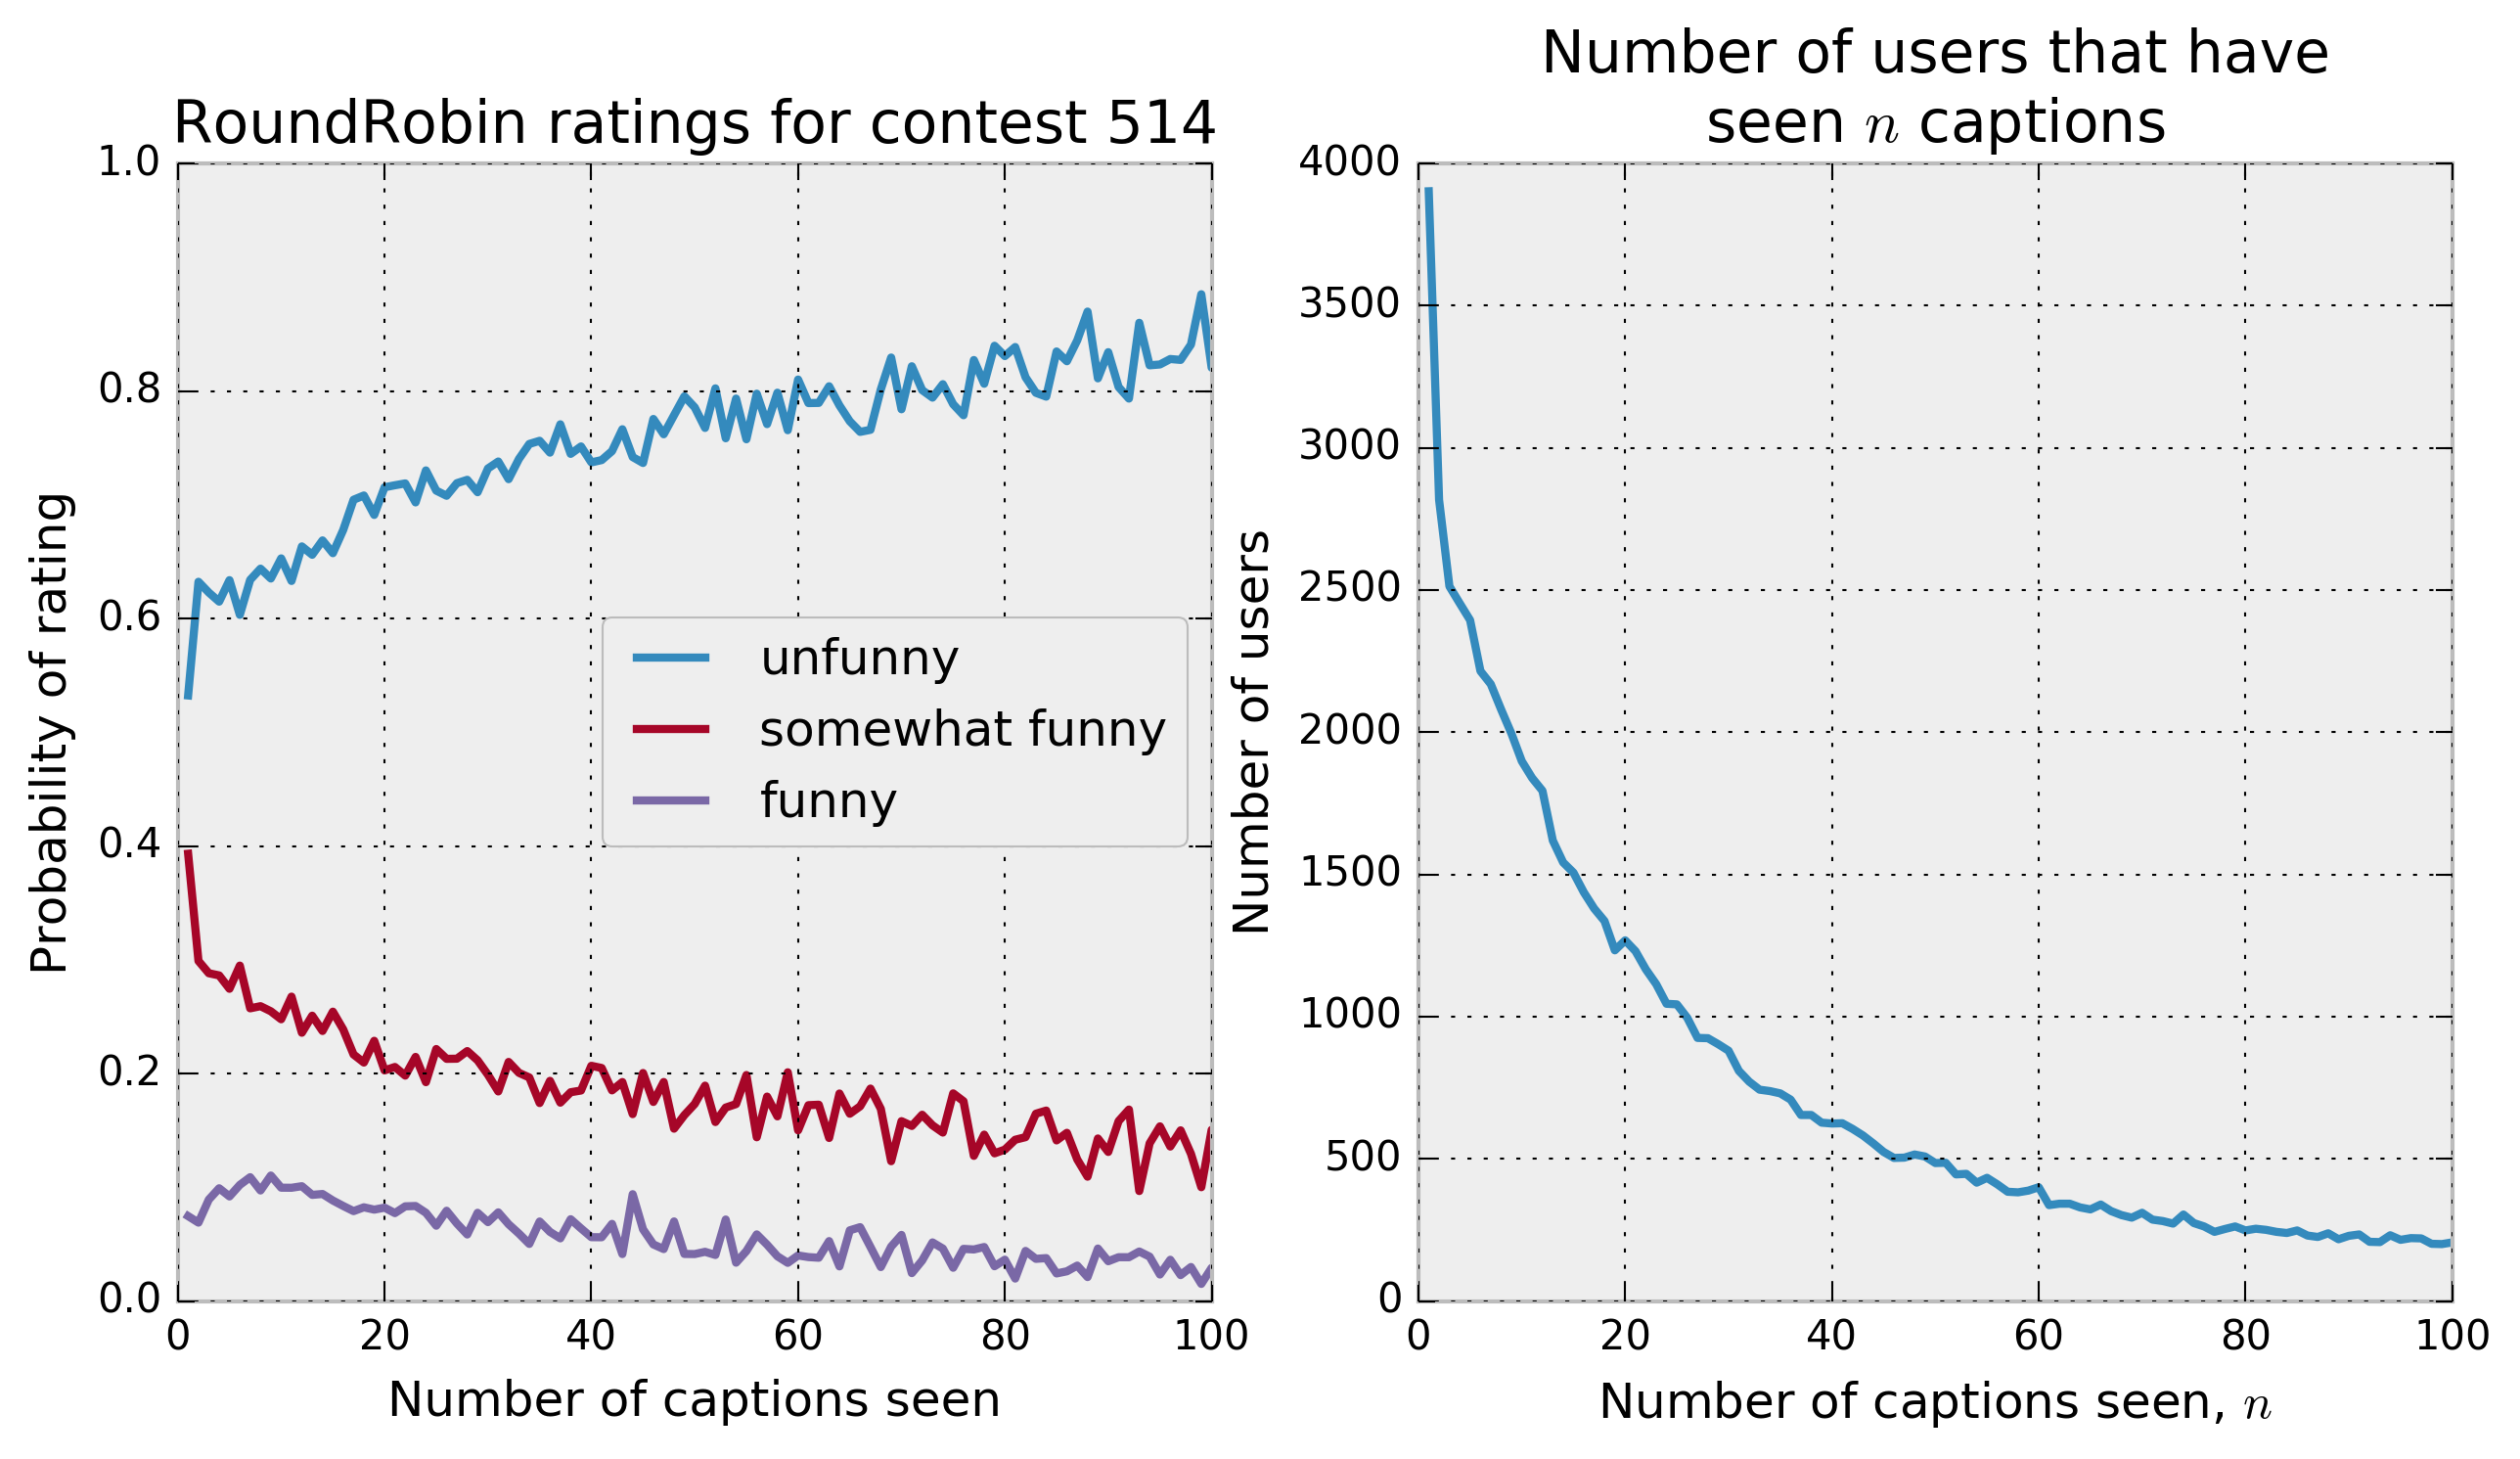

In [ ]:
def plot(alg):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 2, 1)
    df[alg][['unfunny', 'somewhat funny', 'funny']].plot(ax=ax)
    plt.xlim(0, 100)
    plt.title('{} ratings for contest {}'.format(alg, contest))
    plt.ylabel('Probability of rating')
    plt.xlabel('Number of captions seen')

    ax = plt.subplot(1, 2, 2)
    df[alg]['n'].plot(ax=ax, logy=False)
    plt.ylabel('Number of users')
    plt.xlabel('Number of captions seen, $n$')
    plt.title('Number of users that have\nseen $n$ captions')
    plt.xlim(0, 100)
    
for alg in ['RoundRobin', 'LilUCB']:
    fig = plot(alg)
    plt.show()

### Average rating

In [24]:
center = responses.pivot_table(index='number of captions seen', columns='Alg label', values='Rating')
std = responses.pivot_table(index='number of captions seen',
                            columns='Alg label', values='Rating', aggfunc=np.std)

In [25]:
center.head()

Alg label,LilUCB,RoundRobin
number of captions seen,,
1,1.655302,1.542286
2,1.513673,1.436635
3,1.589609,1.466375
4,1.596162,1.484305
5,1.607398,1.458229


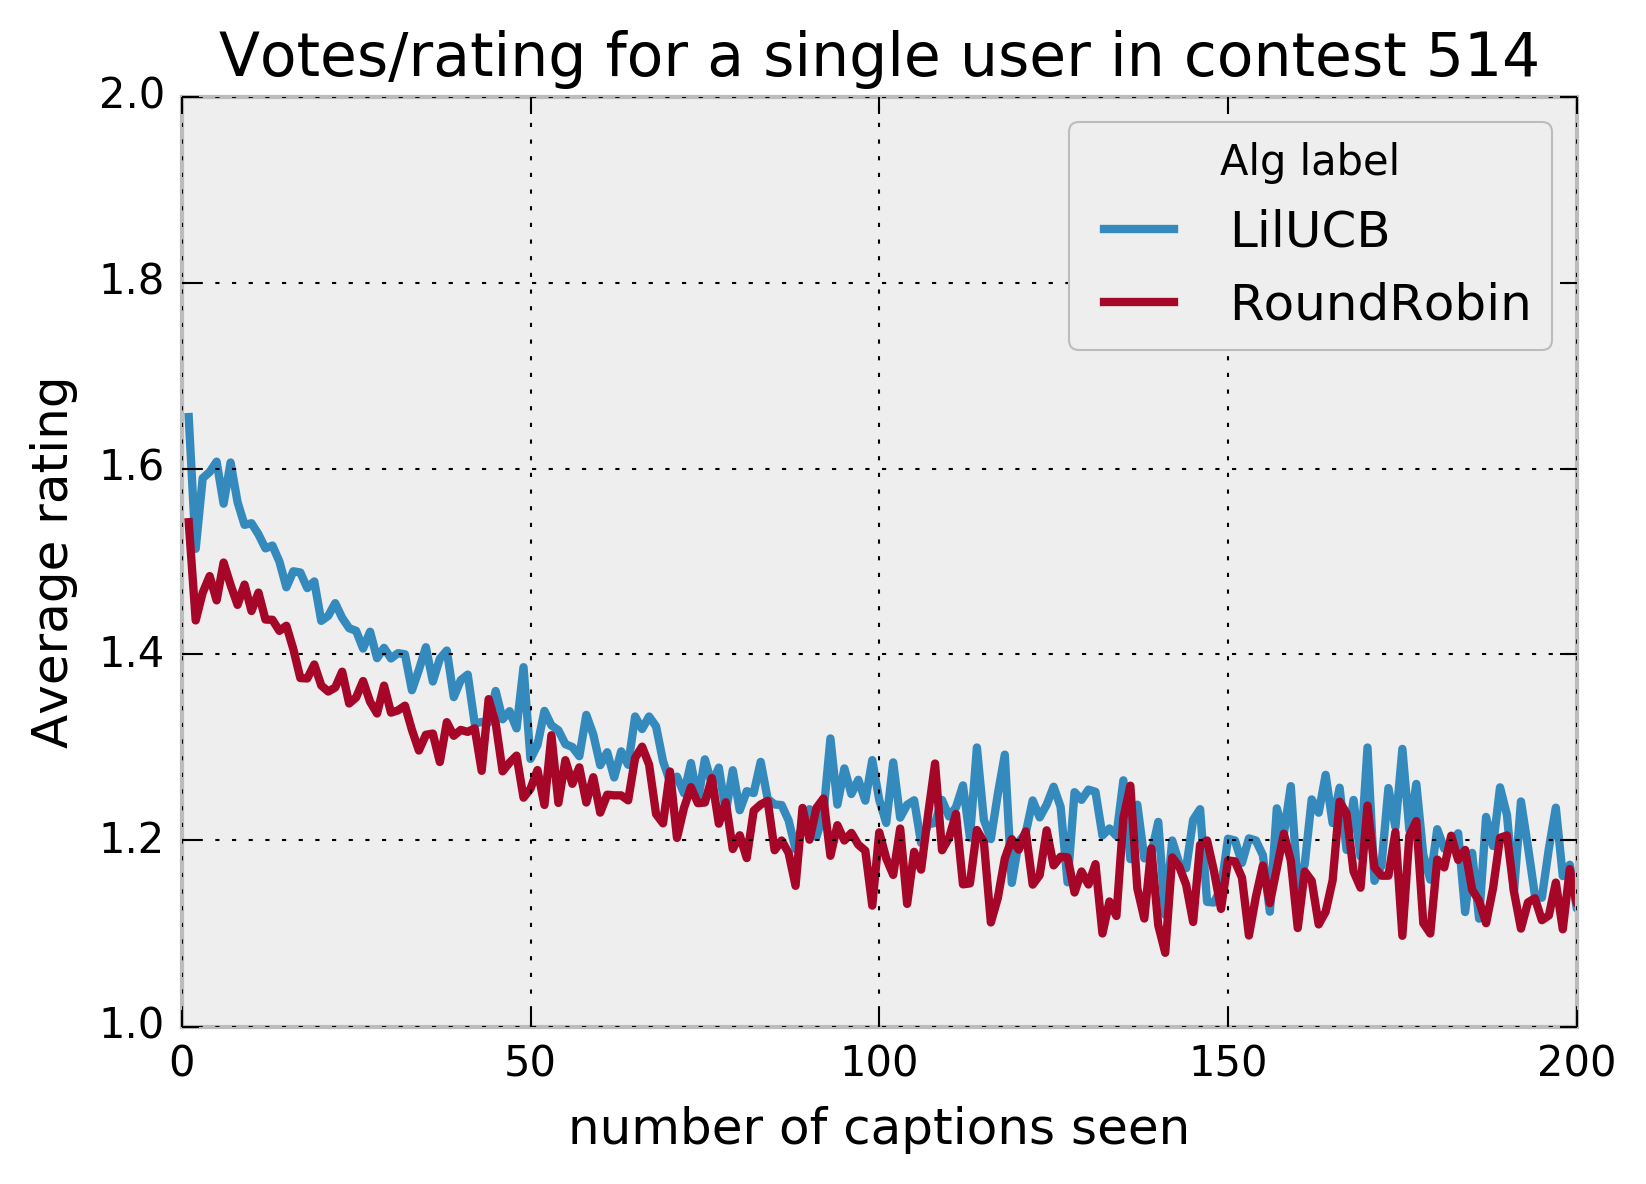

In [26]:
plt.figure()
center.plot()#, yerr=std)
plt.xlim(0, 200)
plt.ylim(1.0, 2.0)
plt.ylabel('Average rating')
plt.title('Votes/rating for a single user in contest {}'.format(contest))
plt.show()